<a href="https://www.inove.com.ar"><img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center"></a>


# Procesamiento de lenguaje natural
## RNN many-to-one

#### Datos
El objecto es utilizar una serie de sucuencias númericas (datos sintéticos) para poner a prueba el uso de las redes RNN. Este ejemplo se inspiró en otro artículo, lo tienen como referencia en el siguiente link:\
[LINK](https://stackabuse.com/solving-sequence-problems-with-lstm-in-keras/)

In [1]:
import re

import numpy as np
import pandas as pd

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional

In [2]:
# Generar datos sintéticos
X = list()
y = list()

# X será una lista de 1 a 45 agrupado de a 3 números consecutivos
# [ [1, 2, 3], [4, 5, 6], ....]
X = [ [x, x+1, x+2] for x in range(1, 46, 3)]

# "y" (target) se obtiene como la suma de cada grupo de 3 números de entrada
y = [sum(x) for x in X]

print("datos X:", X)
print("datos y:", y)

datos X: [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12], [13, 14, 15], [16, 17, 18], [19, 20, 21], [22, 23, 24], [25, 26, 27], [28, 29, 30], [31, 32, 33], [34, 35, 36], [37, 38, 39], [40, 41, 42], [43, 44, 45]]
datos y: [6, 15, 24, 33, 42, 51, 60, 69, 78, 87, 96, 105, 114, 123, 132]


In [3]:
# Cada dato X lo transformarmos en una matriz de 1 fila 1 columna (1x1)
X = np.array(X).reshape(len(X), len(X[0]), 1)
print("datos X:", X)

datos X: [[[ 1]
  [ 2]
  [ 3]]

 [[ 4]
  [ 5]
  [ 6]]

 [[ 7]
  [ 8]
  [ 9]]

 [[10]
  [11]
  [12]]

 [[13]
  [14]
  [15]]

 [[16]
  [17]
  [18]]

 [[19]
  [20]
  [21]]

 [[22]
  [23]
  [24]]

 [[25]
  [26]
  [27]]

 [[28]
  [29]
  [30]]

 [[31]
  [32]
  [33]]

 [[34]
  [35]
  [36]]

 [[37]
  [38]
  [39]]

 [[40]
  [41]
  [42]]

 [[43]
  [44]
  [45]]]


In [5]:
y = np.asanyarray(y)
y.shape

(15,)

### 2 - Entrenar el modelo

In [6]:
input_shape = X[0].shape
input_shape

(3, 1)

In [7]:
output_shape = 1
output_shape

1

In [8]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=input_shape))
model.add(Dense(output_shape))
model.compile(loss='mse',
              optimizer="Adam")

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [9]:
hist = model.fit(X, y, epochs=500, validation_split=0.2, batch_size=5)

Epoch 1/500
3/3 [==============================] - 2s 126ms/step - loss: 4216.9673 - val_loss: 15539.6885
Epoch 2/500
3/3 [==============================] - 0s 13ms/step - loss: 4106.9253 - val_loss: 15132.6484
Epoch 3/500
3/3 [==============================] - 0s 12ms/step - loss: 3985.9014 - val_loss: 14768.7686
Epoch 4/500
3/3 [==============================] - 0s 12ms/step - loss: 3898.4863 - val_loss: 14406.6768
Epoch 5/500
3/3 [==============================] - 0s 12ms/step - loss: 3783.3132 - val_loss: 14054.9229
Epoch 6/500
3/3 [==============================] - 0s 17ms/step - loss: 3678.9307 - val_loss: 13676.4609
Epoch 7/500
3/3 [==============================] - 0s 13ms/step - loss: 3570.4177 - val_loss: 13268.8291
Epoch 8/500
3/3 [==============================] - 0s 15ms/step - loss: 3432.2061 - val_loss: 12823.5674
Epoch 9/500
3/3 [==============================] - 0s 13ms/step - loss: 3264.4641 - val_loss: 12307.0889
Epoch 10/500
3/3 [==============================] - 0s

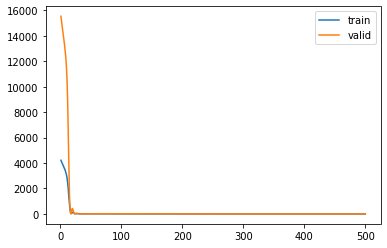

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['loss']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['loss'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_loss'], label='valid')
plt.show()

In [11]:
# Ensayo
x_test = [50, 51, 52]
y_test = sum(x_test)
test_input = np.array([x_test])
test_input = test_input.reshape((1, len(x_test), 1))
y_hat = model.predict(test_input, verbose=0)[0][0]

print("y_test:", y_test)
print("y_hat:", y_hat)

model.evaluate(test_input, np.array([y_test]))

y_test: 153
y_hat: 151.24939
1/1 [==============================] - 0s 15ms/step - loss: 3.0646


3.064636707305908

### 3 - Bidirectional RNN (BRNN)

In [12]:
# En esta oportunidad se utilizará Bidirectional, dentro se especifica
# que lo que se desea hacer bidireccional es una capa LSTM

# En el summary se puede observar que la cantidad de parámetros
# de nuestor nueva capa LSTM bidireccional es el doble que la anterior

model2 = Sequential()
model2.add(Bidirectional(LSTM(64, activation='relu'), input_shape=input_shape))
model2.add(Dense(output_shape))
model2.compile(loss='mse',
              optimizer="Adam")

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 128)               33792     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 33,921
Trainable params: 33,921
Non-trainable params: 0
_________________________________________________________________


In [13]:
hist2 = model2.fit(X, y, epochs=500, validation_split=0.2, batch_size=5)

Epoch 1/500
3/3 [==============================] - 2s 170ms/step - loss: 4056.1389 - val_loss: 14964.9971
Epoch 2/500
3/3 [==============================] - 0s 14ms/step - loss: 3893.6184 - val_loss: 14430.2920
Epoch 3/500
3/3 [==============================] - 0s 14ms/step - loss: 3758.7527 - val_loss: 13841.2529
Epoch 4/500
3/3 [==============================] - 0s 15ms/step - loss: 3583.2073 - val_loss: 13216.1953
Epoch 5/500
3/3 [==============================] - 0s 15ms/step - loss: 3393.5176 - val_loss: 12446.1328
Epoch 6/500
3/3 [==============================] - 0s 14ms/step - loss: 3150.7893 - val_loss: 11465.7861
Epoch 7/500
3/3 [==============================] - 0s 15ms/step - loss: 2868.8740 - val_loss: 10158.0547
Epoch 8/500
3/3 [==============================] - 0s 15ms/step - loss: 2516.8523 - val_loss: 8398.4502
Epoch 9/500
3/3 [==============================] - 0s 15ms/step - loss: 2093.5239 - val_loss: 6139.4629
Epoch 10/500
3/3 [==============================] - 0s 1

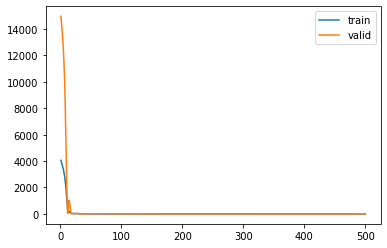

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist2.history['loss']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['loss'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['val_loss'], label='valid')
plt.show()

In [15]:
# Ensayo
x_test = [50, 51, 52]
y_test = sum(x_test)
test_input = np.array([x_test])
test_input = test_input.reshape((1, len(x_test), 1))
y_hat = model2.predict(test_input, verbose=0)[0][0]

print("y_test:", y_test)
print("y_hat:", y_hat)

model2.evaluate(test_input, np.array([y_test]))

y_test: 153
y_hat: 151.8559
1/1 [==============================] - 0s 16ms/step - loss: 1.3090


1.3090088367462158

### 4 - Conclusión
Implementar un modelo bidireccional basado en RNN (en este caso LSTM) es muy sensillo. En este ejemplo no se explotó su potencialidad pero queda como nota de como implementar una capa BRNN.